hw2q2,data.shape (3, 1000)
hw2q2,xValidate.shape,yValidate.shape: (2, 1000) (1000,)
xTrain, yTrain, xValidate, yValidate (2, 100) (100,) (2, 1000) (1000,)
xTrain, yTrain, xValidate, yValidate (100, 2) (100,) (1000, 2) (1000,)
10 batches of size 10:
theta start:
[ 1.38365602 -0.34458338 -0.50803804 -1.3134156  -0.07269325  0.21102434
  1.41292115  0.0759375  -0.11541498  0.08578218]
theta MLE:
[ 1.39596127 -0.36279139 -0.50864559 -0.01575003 -0.04368055  0.22082408
 -0.00592023 -0.00283205 -0.08601787  0.08746708]
theta MAP:
[-0.04734302  0.15571711  0.13743308  0.00581479 -0.02772774 -0.02206103
 -0.01173742 -0.00290605 -0.00571601  0.17502425]

MSE GD: 7.988058688778336
MSE MAP: 4.843545473454954


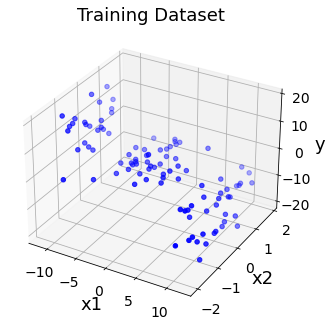

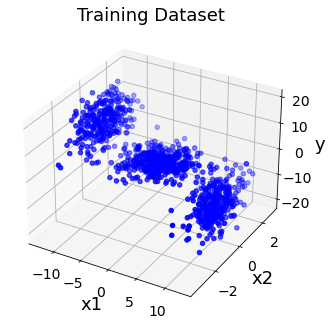

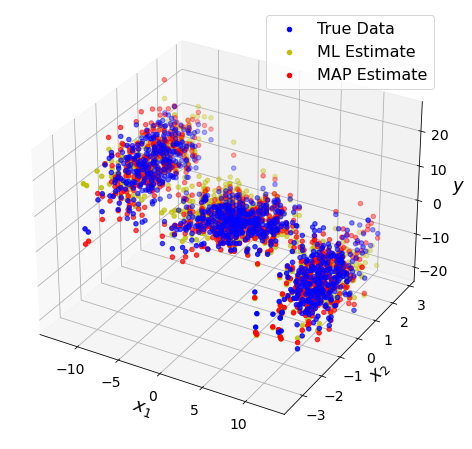

10 batches of size 10:


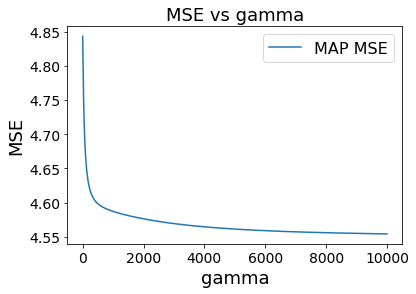

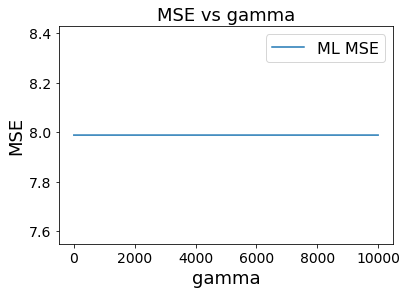

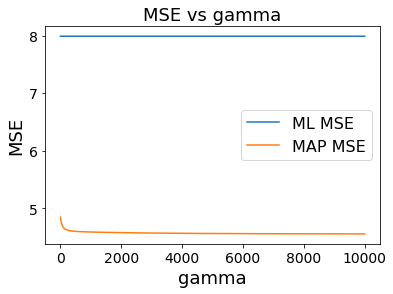

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from math import ceil, floor 
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D

def hw2q2():
    Ntrain = 100
    data = generateData(Ntrain)
    plot3(data[0,:],data[1,:],data[2,:])
    xTrain = data[0:2,:]
    yTrain = data[2,:]
    
    Ntrain = 1000
    data = generateData(Ntrain)
    plot3(data[0,:],data[1,:],data[2,:])
    print("hw2q2,data.shape",data.shape)
    xValidate = data[0:2,:]
    yValidate = data[2,:]
    print("hw2q2,xValidate.shape,yValidate.shape:",xValidate.shape,yValidate.shape)
    
    return xTrain,yTrain,xValidate,yValidate

def generateData(N):
    gmmParameters = {}
    gmmParameters['priors'] = [.3,.4,.3] # priors should be a row vector
    gmmParameters['meanVectors'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])
    gmmParameters['covMatrices'] = np.zeros((3, 3, 3))
    gmmParameters['covMatrices'][:,:,0] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
    gmmParameters['covMatrices'][:,:,1] = np.array([[8, 0, 0], [0, .5, 0], [0, 0, .5]])
    gmmParameters['covMatrices'][:,:,2] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
    x,labels = generateDataFromGMM(N,gmmParameters)
    return x

def generateDataFromGMM(N,gmmParameters):
#    Generates N vector samples from the specified mixture of Gaussians
#    Returns samples and their component labels
#    Data dimensionality is determined by the size of mu/Sigma parameters
    priors = gmmParameters['priors'] # priors should be a row vector
    meanVectors = gmmParameters['meanVectors']
    covMatrices = gmmParameters['covMatrices']
    n = meanVectors.shape[0] # Data dimensionality
    C = len(priors) # Number of components
    x = np.zeros((n,N))
    labels = np.zeros((1,N))
    # Decide randomly which samples will come from each component
    u = np.random.random((1,N))
    thresholds = np.zeros((1,C+1))
    thresholds[:,0:C] = np.cumsum(priors)
    thresholds[:,C] = 1
    for l in range(C):
        indl = np.where(u <= float(thresholds[:,l]))
        Nl = len(indl[1])
        labels[indl] = (l+1)*1
        u[indl] = 1.1
        x[:,indl[1]] = np.transpose(np.random.multivariate_normal(meanVectors[:,l], covMatrices[:,:,l], Nl))
        
    return x,labels

def plot3(a,b,c,mark="o",col="b"):
    pylab.ion()
    fig = pylab.figure()
    ax = Axes3D(fig)
    ax.scatter(a, b, c,marker=mark,color=col)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("y")
    ax.set_title('Training Dataset')


    
np.set_printoptions(suppress=True)
np.random.seed(11)      # seed 7 is really bad for quadratic
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title



# Breaks the matrix X and vector y into batches
def batchify(X, y, batch_size, N):
    X_batch = []
    y_batch = []

    # Iterate over N in batch_size steps, last batch may be < batch_size
    for i in range(0, N, batch_size):
        nxt = min(i + batch_size, N + 1)
        X_batch.append(X[i:nxt, :])
        y_batch.append(y[i:nxt])

    return X_batch, y_batch


def gradient_descent(loss_func, theta0, X, y, N, *args, **kwargs):
    # Mini-batch GD. Stochastic GD if batch_size=1.

    # Break up data into batches and work out gradient for each batch
    # Move parameters theta in that direction, scaled by the step size.

    # Options for total sweeps over data (max_epochs),
    # and parameters, like learning rate and threshold.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6

    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 10

    # Turn the data into batches
    X_batch, y_batch = batchify(X, y, batch_size, N)
    num_batches = len(y_batch)
    print("%d batches of size %d:" % (num_batches, batch_size))

    theta = theta0
    m_t = np.zeros(theta.shape)

    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):
        # print("epoch %d\n" % epoch)
        
        loss_epoch = 0
        for b in range(num_batches):
            X_b = X_batch[b]
            y_b = y_batch[b]
            # print("epoch %d batch %d\n" % (epoch, b))

            # Compute NLL loss and gradient of NLL function
            loss, gradient = loss_func(theta, X_b, y_b, *args)
            loss_epoch += loss
            
            # Steepest descent update
            theta = theta - alpha * gradient
            
            # Terminating Condition is based on how close we are to minimum (gradient = 0)
            if np.linalg.norm(gradient) < epsilon:
                print("Gradient Descent has converged after {} epochs".format(epoch))
                break
        # Storing the history of the parameters and loss values per epoch
        trace['loss'].append(np.mean(loss_epoch))
        trace['theta'].append(theta)
        # print(trace['loss'])
        # Also break epochs loop
        if np.linalg.norm(gradient) < epsilon:
            break

    return theta, trace


def cubic_transformation(X):
    n = X.shape[1]
    phi_X = X
    
    # Take all monic polynomials for a quadratic
    phi_X = np.column_stack((phi_X, X[:, 1] * X[:, 1],              X[:, 1] * X[:, 2],              X[:, 2] * X[:, 2],              \
                                    X[:, 1] * X[:, 1] * X[:, 1],    X[:, 1] * X[:, 1] * X[:, 2],    X[:, 1] * X[:, 2] * X[:, 2],    \
                                    X[:, 2] * X[:, 2] * X[:, 2]
                                    ))

    return phi_X


def lin_reg_loss(theta, X, y, sigma2=1):
    B = X.shape[0]
    predictions = X.dot(theta)
    error = predictions - y
    # The loss function is the sum of squared errors divided by 2*sigma^2
    loss_f = (1 / (2 * sigma2)) * np.sum(error ** 2)
    # The gradient should also consider sigma2
    g = (1 / (B * sigma2)) * X.T.dot(error)
    return loss_f, g

def MAP_gamma(X, y, gamma, sigma2=1):
    # The regularization term now includes sigma2
    reg_term = gamma * sigma2 * np.identity(X.shape[1])
    theta = np.linalg.inv(X.T.dot(X) + reg_term).dot(X.T.dot(y))
    return theta


def mean_square_err(X,y,theta):
    y_predict = X.dot(theta) #+ noiseV
    mse = np.mean((y - y_predict)**2)
    return mse

"""
cubic polynomial y = c(x,theta) + v
           where v = Gauss(0,sigma**2)
x = [1,x1,x2,x1x1,x1x2,x2x2,x1x1x1,x1x1x2,x1x2x2,x2x2x2]
10 terms (including bias)
"""

# Options for mini-batch gradient descent
opts = {}
opts['max_epoch'] = 100
opts['alpha'] = 1e-6
opts['tolerance'] = 1e-3

opts['batch_size'] = 10



def main():
    # mu = np.array([[0,0,0,0,0,0,0,0,0,0]])
    mu = np.zeros(10)
    sigma2 = 1
    sigma = np.identity(10)*sigma2
    mu = 0
    sigma = 1

  
    Ntrain = 100
    Nvalidate = 1000
    xTrain, yTrain, xValidate, yValidate = hw2q2()
    print("xTrain, yTrain, xValidate, yValidate",xTrain.shape, yTrain.shape, xValidate.shape, yValidate.shape)
    xTrain, yTrain, xValidate, yValidate = xTrain.transpose(), yTrain.transpose(), xValidate.transpose(), yValidate.transpose()
    print("xTrain, yTrain, xValidate, yValidate",xTrain.shape, yTrain.shape, xValidate.shape, yValidate.shape)

    noiseT = multivariate_normal.rvs(mu,sigma,Ntrain)
    noiseV = multivariate_normal.rvs(mu,sigma,Nvalidate)

    xAugT = np.column_stack((np.ones(Ntrain), xTrain)) 
    yAug = np.column_stack((np.ones(Ntrain), yTrain)) 
    X3train = cubic_transformation(xAugT) #+ noiseT

    xAugV = np.column_stack((np.ones(Nvalidate), xValidate)) 
    X3validate = cubic_transformation(xAugV) #+ noiseT

    nCubic = X3train.shape[1]
    theta0 = np.random.randn(nCubic)

    theta_gd, trace = gradient_descent(lin_reg_loss, theta0, X3train, yTrain, Ntrain, **opts)
    theta_MAP = MAP_gamma(X3train,yTrain,0)

    #Results
    print('theta start:')
    print(theta0)
    print('theta MLE:')
    print(theta_gd)
    print('theta MAP:')
    print(theta_MAP)
    print()
    # print("Mini-batch GD Theta: ", theta_gd)
    # print("MSE: ", trace['loss'][-1])

    ### Now compare to test data and calc accuracy using Mean Square Error ###
    
    mse_gd = mean_square_err(X3validate,yValidate,theta_gd)
    mse_MAP = mean_square_err(X3validate,yValidate,theta_MAP)
    print('MSE GD:', mse_gd)
    print('MSE MAP:', mse_MAP)

    # y = c + noise

    # X_gd = multivariate_normal.rvs(theta_gd,sigma,Nvalidate) + noiseV
    # X_MAP = multivariate_normal.rvs(theta_MAP,sigma,Nvalidate) + noiseV
    # print()
    y_MAP = X3validate.dot(theta_MAP) + noiseV
    y_gd = X3validate.dot(theta_gd) + noiseV


    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xValidate[:, 0], xValidate[:, 1], yValidate, marker='o', color='b', label='True Data')
    ax.scatter(X3validate[:, 1], X3validate[:, 2], y_gd, marker='o', color='y', label='ML Estimate')
    ax.scatter(X3validate[:, 1], X3validate[:, 2], y_MAP, marker='o', color='r', label='MAP Estimate')
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$y$")
    ax.legend()
    plt.show()

    trials = 100000
    gamma = np.linspace(0.0000000001,10000,trials)
    # print(gamma)
    mse_range = []
    mse_range_ml = []
    theta_ml, trace_ml = gradient_descent(lin_reg_loss, theta0, X3train, yTrain, Ntrain, **opts)

    for i in range(trials):
        
        theta_temp = MAP_gamma(X3train,yTrain,gamma[i])        
        mse_range.append(mean_square_err(X3validate,yValidate,theta_temp))
        mse_range_ml.append(mean_square_err(X3validate, yValidate, theta_ml))
        
    fig1 = plt.figure()
    plt.plot(gamma,mse_range,label='MAP MSE')
    plt.title("MSE vs gamma")
    plt.xlabel('gamma')
    plt.ylabel('MSE')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
    plt.show()
    
    
    fig2 = plt.figure()
    plt.plot(gamma,mse_range_ml,label='ML MSE')
    plt.title("MSE vs gamma")
    plt.xlabel('gamma')
    plt.ylabel('MSE')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
    plt.show()
    
    fig3 = plt.figure()
    plt.plot(gamma,mse_range_ml,label='ML MSE')
    plt.plot(gamma,mse_range,label='MAP MSE')
    plt.title("MSE vs gamma")
    plt.xlabel('gamma')
    plt.ylabel('MSE')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
    plt.show()

    return

if __name__ == '__main__':
    main()